In [22]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [23]:
from fastai import *
from fastai.vision import *
from utils.utils import open_4_channel
from utils.resnet import Resnet4Channel

In [28]:
path = Config.data_path()/'proteinatlas'

In [29]:
label_df = pd.read_csv(path/'train.csv')

In [30]:
# label_df.head()

In [31]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ', classes=[str(i) for i in range(28)])) # 27 classes

In [32]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [33]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [34]:
# test_fnames[:5]

In [35]:
src.add_test(test_fnames, label='0');

src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [36]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [37]:
# get_transforms returns tfms for train & valid: https://docs.fast.ai/vision.transform.html#get_transforms
train_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                            max_lighting=0.05, max_warp=0.)
size = 128

In [38]:
data = (src.transform((train_tfms, _), size=size)
        .databunch().normalize(protein_stats))

In [39]:
# data.show_batch(rows=3, figsize=(12,9))

In [40]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [41]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6], m[1])

In [42]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [43]:
learn = create_cnn(
    data, 
    resnet50, 
    cut=-2, 
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path, 
    metrics=[f1_score]
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


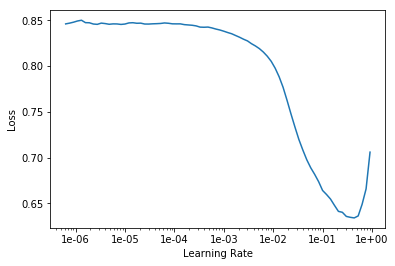

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
lr = 3e-2

In [46]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta


green
/home/jupyter/.fastai/data/proteinatlas/train/06591918-bbb0-11e8-b2ba-ac1f6b6435d0
0


RuntimeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.6/site-packages/fastai/torch_core.py", line 105, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 4 and 3 in dimension 1 at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THTensorMoreMath.cpp:1333


In [47]:
import cv2

In [51]:
f = '/home/jupyter/.fastai/data/proteinatlas/train/06591918-bbb0-11e8-b2ba-ac1f6b6435d0'
cv2.imread(f+'_'+'green'+'.png', 0)

Nothing. Is this a fluke, or are there missing images?

In [53]:
cv2.imread(f+'_'+'red'+'.png', 0)

array([[ 0,  0,  0,  0, ...,  0,  0,  3,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       ...,
       [ 6,  0,  0,  2, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  2, ...,  0,  0,  0,  0],
       [14, 26, 27,  8, ...,  0,  0,  0,  0],
       [78, 61, 23, 21, ...,  0,  0,  0,  0]], dtype=uint8)

Oh boy. There are missing images....

In [54]:
fn = '06591918-bbb0-11e8-b2ba-ac1f6b6435d0'
end = '_green.png'

In [62]:
lookup = {fpath.name:True for fpath in (path/'train').ls()}
lookup[fn+end]

True

So the file is in the directory, but for some reason OpenCV can't read it..

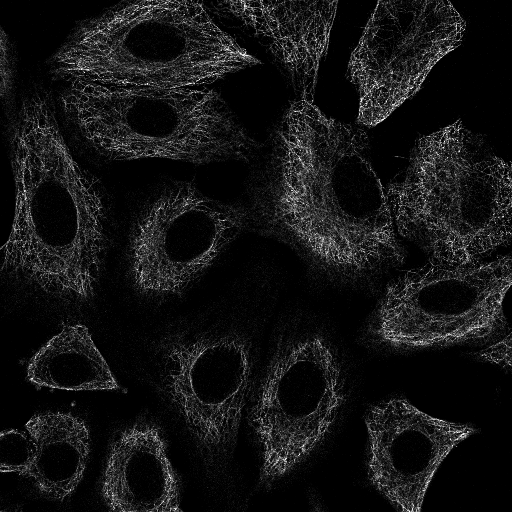

In [71]:
end = '_red.png'
fpath = path/'train'/(fn+end)
open_image(fpath)

In [72]:
end = '_green.png'
fpath = path/'train'/(fn+end)
open_image(fpath)

OSError: image file is truncated

Um.... Looks like... a corrupted download??


So then, what if I re-download and unzip the dataset? Hmm, I appreciate the hash-checking that xView used.

In [74]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/proteinatlas/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/proteinatlas/test'),
 PosixPath('/home/jupyter/.fastai/data/proteinatlas/test.zip'),
 PosixPath('/home/jupyter/.fastai/data/proteinatlas/train.zip'),
 PosixPath('/home/jupyter/.fastai/data/proteinatlas/train'),
 PosixPath('/home/jupyter/.fastai/data/proteinatlas/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/proteinatlas/models')]

In [79]:
# boy Jupyter really leaves the gun loaded & unlocked doesn't it?
!rm -rf {path}/train
!rm -rf {path}/train.zip
!rm -rf {path}/test
!rm -rf {path}/test.zip

In [82]:
!kaggle competitions download -c human-protein-atlas-image-classification -p {path} --force  

  0%|                                                | 0.00/446k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 446k/446k [00:00<00:00, 98.8MB/s]
  0%|                                               | 0.00/1.22M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.22M/1.22M [00:00<00:00, 155MB/s]
 99%|██████████████████████████████████████▊| 4.34G/4.37G [00:17<00:00, 221MB/s]
100%|███████████████████████████████████████| 4.37G/4.37G [00:17<00:00, 271MB/s]
100%|██████████████████████████████████████▉| 13.1G/13.1G [01:44<00:00, 211MB/s]
100%|███████████████████████████████████████| 13.1G/13.1G [01:44<00:00, 135MB/s]


In [83]:
(path/'test').mkdir(exist_ok=True); (path/'train').mkdir(exist_ok=True)

In [84]:
!unzip -q -n {path}/train.zip -d {path}/train
!unzip -q -n {path}/test.zip -d {path}/test

Rerunning data processing & learner construction:

In [85]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ', classes=[str(i) for i in range(28)])) # 27 classes

src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))
test_fnames = [path/'test'/test_id for test_id in test_ids]

src.add_test(test_fnames, label='0');

src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [ ]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

# get_transforms returns tfms for train & valid: https://docs.fast.ai/vision.transform.html#get_transforms
train_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                            max_lighting=0.05, max_warp=0.)
size = 128

In [ ]:
data = (src.transform((train_tfms, _), size=size)
        .databunch().normalize(protein_stats))

In [ ]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6], m[1])

f1_score = partial(fbeta, thresh=0.2, beta=1)

In [ ]:
learn = create_cnn(
    data, 
    resnet50, 
    cut=-2, 
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path, 
    metrics=[f1_score]
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


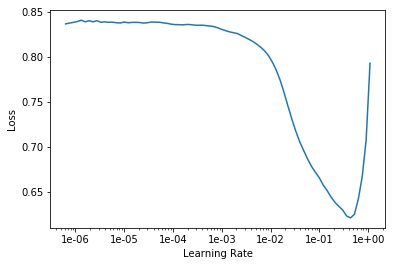

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.156604,0.149386,0.428746


The connection to jupyter (cloud server) cut out, but the above tells me exactly what I wanted to see: The learner was able to make a full pass through the dataset (haven't checked testing data). Meaning: the problem was the data didn't fully download, and some images were corrupted/incomplete.

That's the first time I remember tha that happening with Kaggle. Time to re do this and make a submission.